## Gathering MIMIC data

(This is run on Google Colab)
Notes from Notebook on how to run bigquery in colab - https://github.com/MIT-LCP/mimic-code/discussions/1154

# Setup

Load libraries and connect to the data

Run the following cells to import some libraries and then connect to the database.

In [ ]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import seaborn as sns

# Make pandas dataframes prettier
from IPython.display import display, HTML

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# mount google drive to save files separately
from google.colab import drive

In [ ]:
auth.authenticate_user()

In [ ]:
project_id='your_id_here'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/

/content/drive/My Drive


# Getting intubated patients who stayed in MICU units (includes units that are MICU/SICU)

[BigQuery syntax](https://googleapis.dev/python/bigquery/latest/magics.html).

In [ ]:
%%bigquery vented

select *
from `physionet-data.mimic_derived.ventilation` v join  `physionet-data.mimic_icu.icustays` icus on v.stay_id = icus.stay_id
where ventilation_status like 'InvasiveVent'
AND
  first_careunit LIKE '%MICU%'
  AND last_careunit LIKE '%MICU%'


In [ ]:
vented.shape

(10915, 12)

In [ ]:
vented_unique = vented.drop_duplicates(subset=["hadm_id"])

In [ ]:
vented_unique.shape

(7042, 12)

## Getting pneumonia patients

In [ ]:
%%bigquery pneumonia

SELECT *
from `physionet-data.mimic_hosp.diagnoses_icd` dx
join `physionet-data.mimic_hosp.d_icd_diagnoses` icd
    on dx.icd_code=icd.icd_code
where icd.long_title LIKE '%pneumonia%'

In [ ]:
pneumonia.shape

(10673, 8)

In [ ]:
len(pneumonia.subject_id.unique())

8584

In [ ]:
len(pneumonia.hadm_id.unique())

9999

In [ ]:
pneumonia.long_title.value_counts()

Ventilator associated pneumonia                                                                                           1723
Klebsiella pneumoniae [K. pneumoniae] as the cause of diseases classified elsewhere                                       1425
Personal history of pneumonia (recurrent)                                                                                 1208
Bacterial pneumonia, unspecified                                                                                          1093
Other specified vaccinations against streptococcus pneumoniae [pneumococcus]                                              1007
Unspecified bacterial pneumonia                                                                                            716
Methicillin resistant pneumonia due to Staphylococcus aureus                                                               346
Methicillin susceptible pneumonia due to Staphylococcus aureus                                                 

In [ ]:
pd.set_option("display.max_rows", None)

In [ ]:
names_to_remove = [
    'Other specified vaccinations against streptococcus pneumoniae [pneumococcus]',
    'Need for prophylactic vaccination and inoculation against streptococcus pneumoniae [pneumococcus] and influenza',
    'Cryptogenic organizing pneumonia',
    'Congenital pneumonia',
    'Abscess of lung without pneumonia',    
    'Congenital pneumonia, unspecified',
    'Congenital pneumonia due to staphylococcus',
    'Idiopathic interstitial pneumonia, not otherwise specified',
    'Congenital pneumonia due to other bacterial agents',
    'Desquamative interstitial pneumonia',
    'Congenital pneumonia due to Escherichia coli',
    'Infection by Histoplasma capsulatum, pneumonia',
    'Tuberculous pneumonia [any form], tubercle bacilli found (in sputum) by microscopy',
    'Whooping cough, unspecified species without pneumonia',
    'Congenital pneumonia due to Pseudomonas',
    'Congenital pneumonia due to viral agent',
    'Hypostatic pneumonia, unspecified organism',
    'Lymphoid interstitial pneumonia',
    'Congenital pneumonia due to streptococcus, group B',
    'Tuberculous pneumonia [any form], tubercle bacilli not found (in sputum) by microscopy, but found by bacterial culture',
    'Tuberculous pneumonia [any form], unspecified',  
    'Idiopathic lymphoid interstitial pneumonia'  
]

In [ ]:
pneumonia_clean= pneumonia[~pneumonia['long_title'].isin(names_to_remove)]

In [ ]:
pneumonia_clean.long_title.value_counts()

Ventilator associated pneumonia                                                                               1723
Klebsiella pneumoniae [K. pneumoniae] as the cause of diseases classified elsewhere                           1425
Personal history of pneumonia (recurrent)                                                                     1208
Bacterial pneumonia, unspecified                                                                              1093
Unspecified bacterial pneumonia                                                                                716
Methicillin resistant pneumonia due to Staphylococcus aureus                                                   346
Methicillin susceptible pneumonia due to Staphylococcus aureus                                                 341
Pneumonia due to Klebsiella pneumoniae                                                                         276
Influenza with pneumonia                                                        

In [ ]:
pneumonia_clean.shape

(9084, 8)

In [ ]:
len(pneumonia_clean.hadm_id.unique())

8459

In [ ]:
pneumonia_short = pneumonia_clean.drop_duplicates(subset=["hadm_id"])

In [ ]:
pneumonia_short.shape

(8459, 8)

# Merging pneumonia and vented MICU patients

In [ ]:
micuventpneumonia = vented_unique.merge(pneumonia_short, how='inner', on='hadm_id', indicator=True)

In [ ]:
micuventpneumonia.shape

(1284, 20)

In [ ]:
micuventpneumonia.to_csv("micuventpneumonia3-20-22.csv")

# Patients who had respiratory samples


In [ ]:
%%bigquery respsamples

select hadm_id
from `physionet-data.mimic_hosp.microbiologyevents`
where spec_type_desc in 
("BRONCHOALVEOLAR LAVAGE",
"Mini-BAL",
"TRACHEAL ASPIRATE",
"BRONCHIAL WASHINGS",
"Rapid Respiratory Viral Screen & Culture"
)
    AND hadm_id is not NULL
group by hadm_id

In [ ]:
respsamples.shape

(10603, 1)

In [ ]:
#micu vent + samples
micuventsample = vented_unique.merge(respsamples, how='inner', on='hadm_id', indicator=True)

In [ ]:
micuventsample.shape

(1859, 13)

# MICU, vented, pneumonia dx, resp sample


In [ ]:

micuventpneumoniasample = micuventpneumonia.merge(respsamples, how='inner', on='hadm_id')

In [ ]:
micuventpneumoniasample.shape

(622, 20)

In [ ]:
len(micuventpneumoniasample.stay_id.unique())

622

# Split into days

After discussing - decided to use micu vent pneumonia group of patients for further analysis 


In [ ]:
pt = pd.read_csv("micuventpneumonia3-20-22.csv")

In [ ]:
pt.columns

Index(['Unnamed: 0', 'stay_id', 'starttime', 'endtime', 'ventilation_status',
       'subject_id_x', 'hadm_id', 'stay_id_1', 'first_careunit',
       'last_careunit', 'intime', 'outtime', 'los', 'subject_id_y', 'seq_num',
       'icd_code', 'icd_version', 'icd_code_1', 'icd_version_1', 'long_title',
       '_merge'],
      dtype='object')

In [ ]:
pt2 = pt[['stay_id', 'hadm_id', 'subject_id_x', 'starttime', 'endtime', 'intime', 'outtime','los']]

Ventilation - starttime/endtime, 
ICU stay - intime/outtime


In [ ]:
len(pd.unique(pt2['stay_id'])), len(pd.unique(pt2['hadm_id'])), len(pd.unique(pt2['subject_id_x']))

(1284, 1284, 1200)

In [ ]:
#make a row for each date 

dates = pt2.apply(lambda row: pd.date_range(row['intime'], row['outtime']).to_series(), axis=1) \
            .stack() \
            .droplevel(-1)
dates.name = 'Date'

pt3 = pt2.join(dates)


In [ ]:
pt3['day'] = pd.to_datetime(pt3.Date).dt.date

In [ ]:
pt3['day_number'] = pt3.groupby(['stay_id']).cumcount()+1; 


In [ ]:
pt3.to_csv("micuventpneumonia_byday3-25-22.csv")

# Add ventilation status 

In [ ]:
pt3 = pd.read_csv("MIMIC/micuventpneumonia_byday3-25-22.csv")
pt3.dtypes

Unnamed: 0        int64
stay_id           int64
hadm_id           int64
subject_id_x      int64
starttime        object
endtime          object
intime           object
outtime          object
los             float64
Date             object
day              object
day_number        int64
dtype: object

In [ ]:
pt3['starttime'] = pd.to_datetime(pt3.starttime)
pt3['endtime'] = pd.to_datetime(pt3.endtime)
pt3['Date'] = pd.to_datetime(pt3.Date)

In [ ]:
pt3['vent_yn']=0


In [ ]:
pt3.loc[(pt3.starttime.dt.day <= pt3.Date.dt.day)&(pt3.endtime.dt.day >= pt3.Date.dt.day), "vent_yn"] = 1


In [ ]:
pt3.dtypes

Unnamed: 0               int64
stay_id                  int64
hadm_id                  int64
subject_id_x             int64
starttime       datetime64[ns]
endtime         datetime64[ns]
intime                  object
outtime                 object
los                    float64
Date            datetime64[ns]
day                     object
day_number               int64
vent_yn                  int64
dtype: object

In [ ]:
vent_duration = pt3[['stay_id', 'hadm_id', 'starttime', 'endtime', 'intime', 'outtime','los', 'day', 'day_number', 'vent_yn']]

In [ ]:
pt4=pt3[['stay_id', 'hadm_id', 'subject_id_x', 'intime', 'outtime','los', 'Date', 'day', 'day_number', 'vent_yn']]

In [ ]:
pt4.to_csv("MIMIC/micuventpneumonia_byday_vent3-25-22.csv")

In [ ]:
pt4.dtypes

stay_id                  int64
hadm_id                  int64
subject_id_x             int64
intime                  object
outtime                 object
los                    float64
Date            datetime64[ns]
day                     object
day_number               int64
vent_yn                  int64
dtype: object

# Add SOFA components subset

In [ ]:
%%bigquery sofa_by_day

SELECT stay_id, CAST(starttime AS DATE) AS chart_date, 
    min(pao2fio2ratio_novent) AS pf_novent,
    min(pao2fio2ratio_vent) as pf_vent,
    max(rate_epinephrine) as max_epi,
    max(rate_norepinephrine) as max_norepi,
    min(meanbp_min) as min_map,
    min(gcs_min) as min_gcs,
    min(uo_24hr) as min_uop,
    max(bilirubin_max) as max_bili,
    max(creatinine_max) as max_cr,
    min(platelet_min) as min_plt,
    max(sofa_24hours) as max_sofa,
 FROM `physionet-data.mimic_derived.sofa` 
GROUP BY stay_id, CAST(starttime AS DATE)

In [ ]:
sofa_by_day.dtypes

stay_id         int64
chart_date     object
pf_novent     float64
pf_vent       float64
max_epi       float64
max_norepi    float64
min_map       float64
min_gcs       float64
min_uop       float64
max_bili      float64
max_cr        float64
min_plt       float64
max_sofa        int64
dtype: object

In [ ]:
sofa_by_day['day'] = pd.to_datetime(sofa_by_day.chart_date)

In [ ]:
pt4['day'] = pd.to_datetime(pt4.day)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
pt5 = pd.merge(pt4, sofa_by_day, on=["stay_id", "day"], how="left")

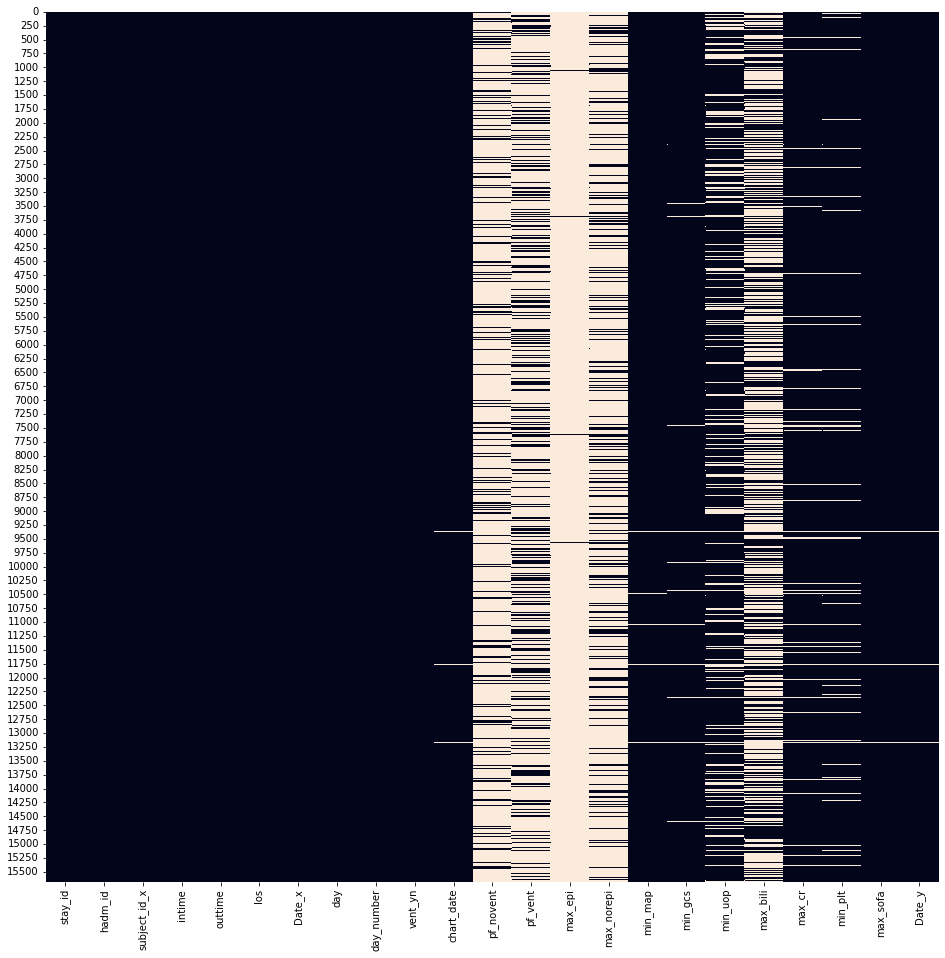

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(
    pt5.isna(),
    cbar=False,
    yticklabels=250,
)

In [ ]:
pt5.to_csv("MIMIC/micu_vent_sofa3-25-22.csv")

In [ ]:
# merge pf vent columns
# drop max_epi column as rarely used
# fill in 0 for NA max norepi as if not documented was likely 0
#check for outliers 

# Dialysis

In [ ]:
%%bigquery dialysis_by_day

SELECT stay_id, CAST(charttime AS DATE) AS  chart_date, MAX(dialysis_active) AS Max
 FROM `physionet-data.mimic_derived.rrt` 
GROUP BY stay_id, CAST(charttime AS DATE)


In [ ]:
dialysis_by_day=dialysis_by_day.rename(columns={'chart_date':'day', 'Max':'dialysis_yn'})

In [ ]:
dialysis_by_day['day'] = pd.to_datetime(dialysis_by_day.day)

In [ ]:
pt6 = pd.merge(pt5, dialysis_by_day, how='left', on=['stay_id', 'day'])

In [ ]:
pt6.to_csv("MIMIC/micu_vent_sofa_dialysis3-25-22.csv")

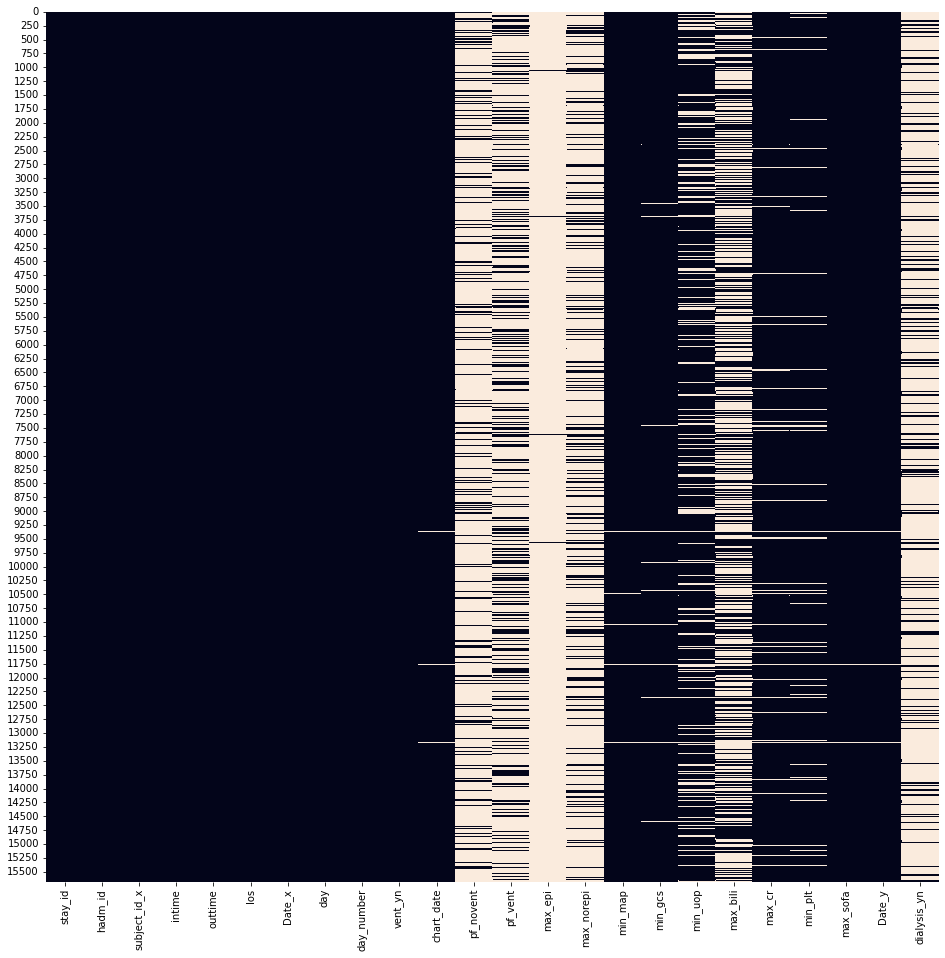

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(
    pt6.isna(),
    cbar=False,
    yticklabels=250,
)
# can we impute no dialysis on days with missing information? 
#is the dialysis derived table only taking those with dialysis present? 
# this looks like it's the case, so we can probably impute 0 for all those without dialysis active that day.


# Ventilator parameters

There are several different types, but CMV appears to be equivalent to Puritan Bennett ACVC and is the vast majority of the modes besides PSV/CPAP and standby modes - let's take settings where modes are CMV

In [ ]:
pt6 = pd.read_csv("MIMIC/micu_vent_sofa_dialysis3-25-22.csv")

In [ ]:
%%bigquery vent_by_day

select stay_id, CAST(charttime AS DATE) AS  chart_date, avg(fio2) as avg_fio2, avg(peep) as avg_peep, avg(respiratory_rate_total) as avg_rr, avg(tidal_volume_observed) as avg_tv, avg(minute_volume) as avg_mv, avg(plateau_pressure) as avg_platpress
from `physionet-data.mimic_derived.ventilator_setting`
where ventilator_mode like '%CMV%'
GROUP BY stay_id, CAST(charttime AS DATE)

In [ ]:
vent_by_day.dtypes

stay_id            int64
chart_date        object
avg_fio2         float64
avg_peep         float64
avg_rr           float64
avg_tv           float64
avg_mv           float64
avg_platpress    float64
dtype: object

In [ ]:
vent_by_day['day'] = pd.to_datetime(vent_by_day.chart_date)

In [ ]:
vent_by_day.dtypes

stay_id                   int64
chart_date               object
avg_fio2                float64
avg_peep                float64
avg_rr                  float64
avg_tv                  float64
avg_mv                  float64
avg_platpress           float64
day              datetime64[ns]
dtype: object

In [ ]:
pt6.dtypes

Unnamed: 0        int64
stay_id           int64
hadm_id           int64
subject_id_x      int64
intime           object
outtime          object
los             float64
Date_x           object
day              object
day_number        int64
vent_yn           int64
chart_date       object
pf_novent       float64
pf_vent         float64
max_epi         float64
max_norepi      float64
min_map         float64
min_gcs         float64
min_uop         float64
max_bili        float64
max_cr          float64
min_plt         float64
max_sofa        float64
Date_y           object
dialysis_yn     float64
dtype: object

In [ ]:
pt6=pt6.drop(columns=['Date_y', 'Date_x'])

In [ ]:
pt6['day'] = pd.to_datetime(pt6.day)

In [ ]:
pt6.dtypes

Unnamed: 0               int64
stay_id                  int64
hadm_id                  int64
subject_id_x             int64
intime                  object
outtime                 object
los                    float64
day             datetime64[ns]
day_number               int64
vent_yn                  int64
chart_date              object
pf_novent              float64
pf_vent                float64
max_epi                float64
max_norepi             float64
min_map                float64
min_gcs                float64
min_uop                float64
max_bili               float64
max_cr                 float64
min_plt                float64
max_sofa               float64
dialysis_yn            float64
dtype: object

In [ ]:
pt7 = pd.merge(pt6, vent_by_day, how='left', on=['stay_id', 'day'])

In [ ]:
# discordance - some of these may make sense such as vent =1 but parameters =NA if someone was getting pressure support
# but I'm also getting options when vent=0 but parameters have values ?

# Suggestions from Thomas:
#try with minimal necessary columns 
#counting up mismatched and how mismatched 
#start/end time is off? 

#maybe there are multiple intubations in each ICU stay that is not getting captured in this table 
#let's go back and examine this in bq for stayid 32950965
#yup, there are multiple start/endtimes for ventilation that I probably threw out when counting initially 
#will need to pull these again to properly populate the vent_yn column 
#or can we just use the full vent information to populate this column? but then only full control vent settings 
#also, does any of this matter? 
#see below section troubleshoot for examining of this section - pulling the multiple examples does improve the match but it's still not perfect

In [ ]:

%%bigquery example_stay

SELECT *
FROM `physionet-data.mimic_derived.ventilation` 
where stay_id=32950965


# other vitals

In [ ]:
%%bigquery vitals_by_day

SELECT stay_id, CAST(charttime AS DATE) AS chart_date, 
    min(heart_rate) AS min_hr,
    max(heart_rate) as max_hr,
    min(resp_rate) as min_rr,
    max(resp_rate) as max_rr,
    min(temperature) as min_temp,
    max(temperature) as max_temp, 
    min(spo2) as min_spo2,
 FROM `physionet-data.mimic_derived.vitalsign` 
GROUP BY stay_id, CAST(charttime AS DATE)


In [ ]:
vitals_by_day['day'] = pd.to_datetime(vitals_by_day.chart_date)

In [ ]:
pt8 = pd.merge(pt7, vitals_by_day, how='left', on=['stay_id', 'day'])

# ABGs

In [ ]:

#po2 is weird and since we have pf ratios separately, we will only pull ph and pc02

%%bigquery abg_by_day

select hadm_id, CAST(charttime AS DATE) AS  chart_date, avg(ph) as avg_ph, avg(pco2) as avg_pco2, 
from `physionet-data.mimic_derived.bg`
where hadm_id is not null and specimen='ART.'
GROUP BY hadm_id, CAST(charttime AS DATE)

In [ ]:
abg_by_day['day'] = pd.to_datetime(abg_by_day.chart_date)

In [ ]:
pt9 = pd.merge(pt8, abg_by_day, how='left', on=['hadm_id', 'day'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chart_date_x'} in the result is deprecated and will raise a MergeError in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
pt9.columns

Index(['Unnamed: 0', 'stay_id', 'hadm_id', 'subject_id_x', 'intime', 'outtime',
       'los', 'day', 'day_number', 'vent_yn', 'chart_date_x', 'pf_novent',
       'pf_vent', 'max_epi', 'max_norepi', 'min_map', 'min_gcs', 'min_uop',
       'max_bili', 'max_cr', 'min_plt', 'max_sofa', 'dialysis_yn',
       'chart_date_y', 'avg_fio2', 'avg_peep', 'avg_rr', 'avg_tv', 'avg_mv',
       'avg_platpress', 'chart_date_x', 'min_hr', 'max_hr', 'min_rr', 'max_rr',
       'min_temp', 'max_temp', 'min_spo2', 'chart_date_y', 'avg_ph',
       'avg_pco2'],
      dtype='object')

In [ ]:
pt9 = pt9.drop(columns=['chart_date_x', 'chart_date_y'])

In [ ]:
pt9.to_csv("MIMIC/micu_vent_sofa_dialysis_abg_vs3-28-22.csv")

# ECMO

Found ce.itemid=229278 is di.label = 'Sweep (ECMO)' so pulling any documented ECMO sweep in for that day means patient was on ECMO that day 

In [ ]:
%%bigquery ecmo_by_day

SELECT stay_id, CAST(charttime AS DATE) AS  chart_date, STRING_AGG(value,' ') as agg_ecmo_sweep
from `physionet-data.mimic_icu.chartevents` ce
where ce.itemid=229278
GROUP BY stay_id, CAST(charttime AS DATE)

In [ ]:
ecmo_by_day['ecmo_yn'] = 1

In [ ]:
ecmo_by_day['day'] = pd.to_datetime(ecmo_by_day.chart_date)

In [ ]:
ecmo_by_day = ecmo_by_day.drop(columns=['agg_ecmo_sweep'])

In [ ]:
pt10 = pd.merge(pt9, ecmo_by_day, how='left', on=['stay_id', 'day']) 

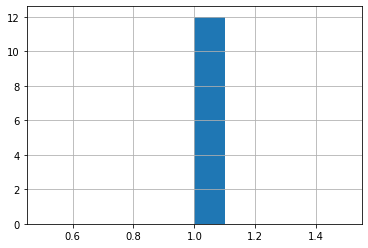

In [ ]:
pt10['ecmo_yn'].hist() #12 ecmo patients in this cohort 

In [ ]:
pt10.columns

Index(['Unnamed: 0', 'stay_id', 'hadm_id', 'subject_id_x', 'intime', 'outtime',
       'los', 'day', 'day_number', 'vent_yn', 'pf_novent', 'pf_vent',
       'max_epi', 'max_norepi', 'min_map', 'min_gcs', 'min_uop', 'max_bili',
       'max_cr', 'min_plt', 'max_sofa', 'dialysis_yn', 'avg_fio2', 'avg_peep',
       'avg_rr', 'avg_tv', 'avg_mv', 'avg_platpress', 'min_hr', 'max_hr',
       'min_rr', 'max_rr', 'min_temp', 'max_temp', 'min_spo2', 'avg_ph',
       'avg_pco2', 'chart_date', 'ecmo_yn'],
      dtype='object')

In [ ]:
pt10 = pt10.drop(columns=['Unnamed: 0','chart_date'])

In [ ]:
pt10.to_csv("MIMIC/micu_vent_sofa_dialysis_abg_vs_ecmo3-28-22.csv")

# Troubleshoot/fix vent_yn column




In [ ]:
pt10 = pd.read_csv("MIMIC/micu_vent_sofa_dialysis_abg_vs_ecmo3-28-22.csv")

In [ ]:
pt10.columns

Index(['Unnamed: 0', 'stay_id', 'hadm_id', 'subject_id_x', 'intime', 'outtime',
       'los', 'day', 'day_number', 'vent_yn', 'pf_novent', 'pf_vent',
       'max_epi', 'max_norepi', 'min_map', 'min_gcs', 'min_uop', 'max_bili',
       'max_cr', 'min_plt', 'max_sofa', 'dialysis_yn', 'avg_fio2', 'avg_peep',
       'avg_rr', 'avg_tv', 'avg_mv', 'avg_platpress', 'min_hr', 'max_hr',
       'min_rr', 'max_rr', 'min_temp', 'max_temp', 'min_spo2', 'avg_ph',
       'avg_pco2', 'ecmo_yn'],
      dtype='object')

In [ ]:
pt11 = pt10[['stay_id', 'day', 'vent_yn','avg_peep']]

In [ ]:
pt11['peep_yn'] = 0
pt11.loc[pt11['avg_peep']>0, 'peep_yn']=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
pt11.loc[pt11['avg_peep']>0, 'peep_yn']=1

#df.loc[df['column name'] condition, 'new column name'] = 'value if condition is met'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
#confusion_matrix(y_true, y_pred)
confusion_matrix(pt11['peep_yn'], pt11['vent_yn'])

array([[8582, 1584],
       [3331, 2180]])

In [ ]:
%%bigquery ventyn_by_day

select *
from `physionet-data.mimic_derived.ventilation` 
where ventilation_status like 'InvasiveVent'

In [ ]:
pt = pd.read_csv("MIMIC/micuventpneumonia3-20-22.csv")

In [ ]:
pt = pt['stay_id']

In [ ]:
ventyn = pd.merge(pt, ventyn_by_day, how='left', on='stay_id')

In [ ]:
#make a row for each date 

dates = ventyn.apply(lambda row: pd.date_range(row['starttime'], row['endtime']).to_series(), axis=1) \
            .stack() \
            .droplevel(-1)
dates.name = 'Date'

ventyn_by_day2 = ventyn.join(dates)


In [ ]:
ventyn_by_day2['Date_day'] = pd.to_datetime(ventyn_by_day2.Date).dt.date

In [ ]:
ventyn_by_day2['day'] = pd.to_datetime(ventyn_by_day2.Date_day)

In [ ]:
ventyn_by_day2.dtypes

stay_id                        int64
starttime             datetime64[ns]
endtime               datetime64[ns]
ventilation_status            object
Date                  datetime64[ns]
day                   datetime64[ns]
Date_day                      object
dtype: object

In [ ]:
ventyn_by_day3=ventyn_by_day2[['stay_id', 'day', 'ventilation_status']]


In [ ]:
pt10['day'] = pd.to_datetime(pt10.day)

In [ ]:
ventyn_by_day3.dtypes

stay_id                        int64
day                   datetime64[ns]
ventilation_status            object
dtype: object

In [ ]:
pt10.columns

Index(['Unnamed: 0', 'stay_id', 'hadm_id', 'subject_id_x', 'intime', 'outtime',
       'los', 'day', 'day_number', 'vent_yn', 'pf_novent', 'pf_vent',
       'max_epi', 'max_norepi', 'min_map', 'min_gcs', 'min_uop', 'max_bili',
       'max_cr', 'min_plt', 'max_sofa', 'dialysis_yn', 'avg_fio2', 'avg_peep',
       'avg_rr', 'avg_tv', 'avg_mv', 'avg_platpress', 'min_hr', 'max_hr',
       'min_rr', 'max_rr', 'min_temp', 'max_temp', 'min_spo2', 'avg_ph',
       'avg_pco2', 'ecmo_yn'],
      dtype='object')

In [ ]:
len(pt10.subject_id_x.unique()), 

(1200,)

In [ ]:
#merge just columsn of interest
pt10_small = pt10[['stay_id', 'day', 'vent_yn', 'avg_peep','avg_fio2', 'avg_rr', 'avg_tv', 'avg_mv', 'avg_platpress']]

In [ ]:
pt12 = pd.merge(pt10_small, ventyn_by_day3, how='left', on=['stay_id', 'day'])


In [ ]:
pt12 = pt12.drop(columns=['vent_yn'])

In [ ]:
pt12.ventilation_status

0        InvasiveVent
1        InvasiveVent
2                 NaN
3                 NaN
4        InvasiveVent
             ...     
15751             NaN
15752             NaN
15753             NaN
15754             NaN
15755             NaN
Name: ventilation_status, Length: 15756, dtype: object

In [ ]:
pt13 = pt12[['stay_id', 'day', 'vent_yn','avg_peep', 'ventilation_status']]


In [ ]:
pt13['peep_yn'] = 0
pt13.loc[pt13['avg_peep']>0, 'peep_yn']=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
pt13['ventstatus_yn'] = 0
pt13.loc[pt13['ventilation_status']=='InvasiveVent', 'ventstatus_yn']=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
#confusion_matrix(y_true, y_pred)
confusion_matrix(pt13['peep_yn'], pt13['ventstatus_yn'])

array([[6895, 3311],
       [ 827, 4723]])

In [ ]:
SELECT count (distinct stay_id)
 FROM `physionet-data.mimic_derived.ventilation` 
 where ventilation_status = 'InvasiveVent'

#24205 


select count (distinct stay_id)
from `physionet-data.mimic_derived.ventilator_setting`
where ventilator_mode LIKE '%CMV%'
# 38722
# 20201 - CMV mode 



This is better but there are still 827 where there are ventilator parameters but not looking like they are on the ventilator?  

Unclear ground truth; discussed and will discard vent_yn column.


# RASS code 

In [ ]:
#adding late 

pt10 = pd.read_csv("MIMIC/micu_vent_sofa_dialysis_abg_vs_ecmo3-28-22.csv")

In [ ]:
pt10['day'] = pd.to_datetime(pt10.day)

In [ ]:
%%bigquery rass_by_day


SELECT stay_id, CAST(charttime AS DATE) AS  chart_date,   min(valuenum) AS min_rass,  max(valuenum) as max_rass,
from `physionet-data.mimic_icu.chartevents` ce
where ce.itemid=228096
GROUP BY stay_id, CAST(charttime AS DATE)

#argh, doesn't have median, will have to do this the hard way 

In [ ]:
rass_by_day['day'] = pd.to_datetime(rass_by_day.chart_date)

In [ ]:
%%bigquery rass_all

SELECT stay_id, charttime,  valuenum
from `physionet-data.mimic_icu.chartevents` ce
where ce.itemid=228096

In [ ]:
rass_all['day'] = pd.to_datetime(rass_all.charttime).dt.date

In [ ]:
agg_rass2 = rass_all.groupby(["stay_id", "day"]).agg({"valuenum": "median"}).reset_index()


In [ ]:
agg_rass2['day'] = pd.to_datetime(agg_rass2.day)

In [ ]:
agg_rass2 = agg_rass2.rename(columns={'valuenum':'median_rass'})
#df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})

In [ ]:
pt11 = pd.merge(pt10, agg_rass2, how='left', on=['stay_id', 'day'])

In [ ]:
pt11.to_csv("MIMIC/micu_vent_sofa_dialysis_abg_vs_ecmo_rass4-20-22.csv")

# raw GCS

In [ ]:
%%bigquery raw_gcs

SELECT stay_id, charttime, itemid, valuenum, value
from `physionet-data.mimic_icu.chartevents` ce
where ce.itemid in (223900, 223901,220739)

In [ ]:
%%bigquery raw_gcs_verbal

select stay_id, CAST(charttime AS DATE) AS  chart_date, min(valuenum) as min_verbal
from `physionet-data.mimic_icu.chartevents` ce
where ce.itemid=223900
GROUP BY stay_id, CAST(charttime AS DATE)

In [ ]:
--    223900 GCS - Verbal Response
--    223901 GCS - Motor Response
--    220739 GCS - Eye Opening

In [ ]:
%%bigquery raw_gcs_motor

select stay_id, CAST(charttime AS DATE) AS  chart_date, min(valuenum) as min_motor
from `physionet-data.mimic_icu.chartevents` ce
where ce.itemid=223901
GROUP BY stay_id, CAST(charttime AS DATE)

In [ ]:
%%bigquery raw_gcs_eye

select stay_id, CAST(charttime AS DATE) AS  chart_date, min(valuenum) as min_eye
from `physionet-data.mimic_icu.chartevents` ce
where ce.itemid=220739
GROUP BY stay_id, CAST(charttime AS DATE)

In [ ]:
raw_gcs_verbal['day'] = pd.to_datetime(raw_gcs_verbal.chart_date)
raw_gcs_motor['day'] = pd.to_datetime(raw_gcs_motor.chart_date)
raw_gcs_eye['day'] = pd.to_datetime(raw_gcs_eye.chart_date)

In [ ]:

raw_gcs_verbal_motor = pd.merge(raw_gcs_verbal, raw_gcs_motor, how='outer', on=['stay_id', 'day'])

In [ ]:
raw_gcs_verbal_motor_eye = pd.merge(raw_gcs_verbal_motor, raw_gcs_eye, how='outer', on=['stay_id', 'day'])

In [ ]:
import seaborn as sns

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(
    raw_gcs_verbal_motor_eye.isna(),
    cbar=False,
    yticklabels=250,
)

In [ ]:
raw_gcs_verbal_motor_eye.isnull().sum(axis = 0)

stay_id           0
chart_date_x    296
min_verbal      296
day               0
chart_date_y    472
min_motor       472
chart_date      127
min_eye         127
dtype: int64

In [ ]:
raw_gcs_verbal_motor_eye_clean = raw_gcs_verbal_motor_eye.drop(columns=['chart_date_x', 'chart_date_y','chart_date'])

In [ ]:
pt12 = pd.merge(pt11, raw_gcs_verbal_motor_eye_clean, how='left', on=['stay_id', 'day'])

In [ ]:
pt12.isnull().sum(axis = 0)

Unnamed: 0           0
stay_id              0
hadm_id              0
subject_id_x         0
intime               0
outtime              0
los                  0
day                  0
day_number           0
vent_yn              0
pf_novent        12882
pf_vent          10982
max_epi          15607
max_norepi       12062
min_map             68
min_gcs            131
min_uop           3026
max_bili          8749
max_cr             740
min_plt            821
max_sofa            38
dialysis_yn      12623
avg_fio2         10179
avg_peep         10153
avg_rr           10256
avg_tv           10172
avg_mv           10211
avg_platpress    10938
min_hr              43
max_hr              43
min_rr              47
max_rr              47
min_temp           185
max_temp           185
min_spo2            60
avg_ph            8505
avg_pco2          8505
ecmo_yn          15665
median_rass       2716
min_verbal         150
min_motor          152
min_eye            142
dtype: int64

In [ ]:
pt12.to_csv("MIMIC/micu_vent_sofa_dialysis_abg_vs_ecmo_rass_rawgcs4-20-22.csv")

# cleaning steps

In [ ]:
pt12 = pt12.drop(columns=['Unnamed: 0','Unnamed: 0.1'])
pt12 = pt12.drop(columns=['max_epi', 'hadm_id', 'subject_id_x'])# drop max_epi column as rarely used
pt12['pf_ratio'] = pt12[['pf_novent','pf_vent']].mean(axis=1)
pt12 = pt12.drop(columns=['pf_novent','pf_vent'])

In [ ]:
pt12['max_norepi']=pt12['max_norepi'].fillna(0)
pt12['ecmo_yn']=pt12['ecmo_yn'].fillna(0)
pt12['dialysis_yn']=pt12['dialysis_yn'].fillna(0)

In [ ]:
pt12 = pd.read_csv("MIMIC/data4-20-22.csv")

# add in mortality data

In [ ]:
data = pd.read_csv("MIMIC/data4-20-22.csv")

In [ ]:
#add in mortality data

mort = pd.read_csv("micu_vent_stay7-8-22.csv", index_col=0)
mort


In [ ]:
mort2 = mort[['stay_id_1', 'discharge_location', 'hospital_expire_flag']]
mort2

In [ ]:
mort2[mort2.discharge_location=='DIED'].hospital_expire_flag.value_counts()

In [ ]:
mort2.rename(columns = {'stay_id_1':'stay_id'}, inplace = True)
mort2=mort2.reset_index(drop=True) 

In [ ]:
data_mort = pd.merge(data, mort2, how='left', on='stay_id')

In [ ]:
#make levo dose 0 = na and add levo flag

data_mort['levo_flag'] = np.where(data_mort['max_norepi']==0, 0, 1)

In [ ]:
data_mort.to_csv("mimic_data_mort_levoflag7-13-22.csv")

In [ ]:
#drop duplicates
data = pd.read_csv("mimic_data_mort_levoflag_dropdup7-15-22.csv", index_col=0)
data=data.drop_duplicates().reset_index()
data=data.drop(columns=['index','Unnamed: 0.1'])
data.to_csv("mimic_data7-19-22.csv")